In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio

mpl.rcParams['figure.figsize'] = [14.0, 6.0]

In [67]:
max_safe_exponent = np.log(2)*(np.finfo(float).maxexp-1)

def bump_function(t, t0, t1):
    """Smooth function going from 0 before t0 to 1 after t1, with C^infty transition in between"""
    assert t0 <= t1
    f = np.zeros_like(t)
    if t0 >= t[-1]:
        return f
    f[t >= (t0+t1)/2] = 1.0
    if t1 <= t[0]:
        return f
    transition_indices = (t0 < t) & (t < t1)
    transition = (t[transition_indices]-t0) / (t1 - t0)
    transition = 1.0/transition - 1.0/(1.0-transition)
    safe_indices = (transition < max_safe_exponent)
    transition_indices[transition_indices] = safe_indices
    f[transition_indices] = 1.0 / (1.0 + np.exp(transition[safe_indices]))
    return f

In [2]:
sampling_rate = 4096.0 # Hz
dt = 1/sampling_rate
with h5py.File('GW150914/GW150914_tutorial/H-H1_LOSC_4_V1-1126259446-32.hdf5') as f:
    h = f['strain/Strain'][:]
t = np.arange(len(h)) / sampling_rate
htilde = dt * np.fft.rfft(h)
frequencies = np.fft.rfftfreq(len(h), dt)

<IPython.core.display.Javascript object>


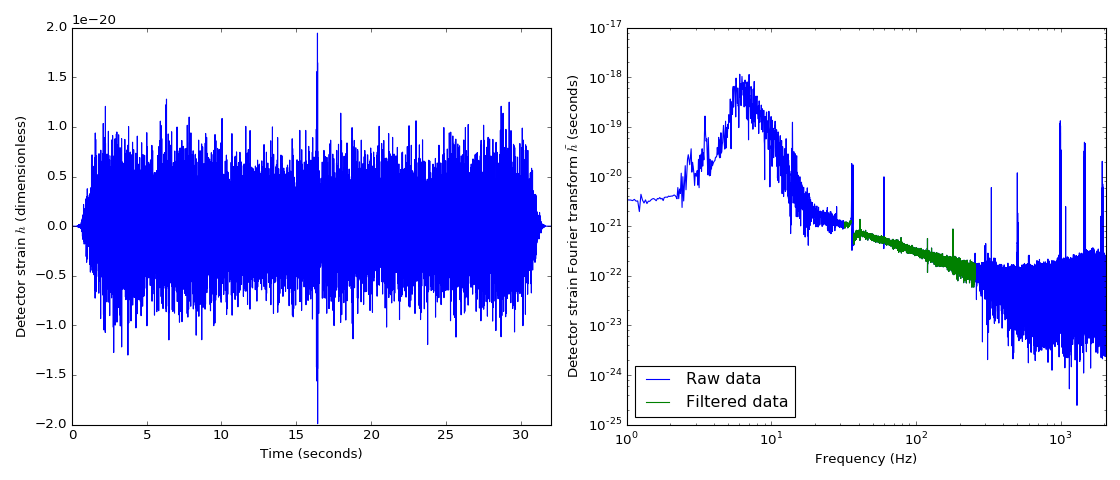

In [88]:
def filter_and_plot(sliders, notch_filters):
    # Once new output is available, clear the old output
    clear_output(wait=True)

    # Get levels from sliders
    levels = np.ones_like(frequencies)
    slider_values = [s.value for s in sliders]
    for i, f in enumerate(frequency_bin_upper_ends):
        if i==0:
            f_last = 0.0
        levels[(frequencies >= f_last) & (frequencies < f)] = slider_values[i]/100.0
        f_last = f

    # Get notch filters (if any)
    for notch_filter in notch_filters.children:
        f_begin, f_end, f_bool = [child.value for child in notch_filter.children if not isinstance(child, widgets.Label)]
        if (f_bool is True) and (f_begin<f_end):
            levels[(frequencies >= f_begin) & (frequencies < f_end)] = 0.0
    
    # Filter the data
    hprime = len(frequencies) * np.fft.irfft(htilde*levels)
    
    # Smooth the beginning and end, so there are no loud spikes as the audio turns on and off
    hprime *= bump_function(t, 0, 3.0) * (1-bump_function(t, t[-1]-3.0, t[-1]))
    
    # Plot
    plt.close('all')
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(t, hprime)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Detector strain $h$ (dimensionless)')
    ax1.set_xlim(xmax=t[-1]);
    ax2.loglog(frequencies, abs(htilde), label='Raw data')
    ax2.loglog(frequencies, abs(htilde*levels), label='Filtered data')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel(r'Detector strain Fourier transform $\tilde{h}$ (seconds)')
    ax2.set_xlim(1, sampling_rate/2)
    ax2.legend(loc='lower left');
    f.tight_layout()
    display(Audio(data=hprime, rate=int(sampling_rate), autoplay=False))
    

frequency_bin_upper_ends = np.logspace(3, 11, num=17, base=2)

gap_filler = widgets.Label("", layout=widgets.Layout(flex='1 1 auto'))
labels = widgets.VBox([widgets.Label("Frequency (Hz)"), gap_filler, widgets.Label("Amplitude (%)")], width='110px')
separator = widgets.VBox([], border='1px solid #ccc', width='0px')

sliders = [widgets.FloatSlider(min=0, max=100, step=1.0, value=100.0, height='auto', readout_format='.0f',
                               orientation='vertical', padding=6, description=str(int(freq)))
           for freq in frequency_bin_upper_ends]

for i, level in enumerate([0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 67.0, 29.0, 0.0, 0.0, 0.0]):
    sliders[i].value = level

# for slider in sliders:
#     slider.observe(lambda change: filter_and_plot(sliders, notch_filters), type='change', names='value')
#     slider.continuous_update = False

equalizer = widgets.HBox(children=[labels, separator]+sliders+[separator], width='{0}px'.format(100*len(sliders)), height='200px')
display(equalizer)

notch_filters = widgets.VBox([], width='450px')
def add_notch_filter():
    new_filter = widgets.HBox([widgets.FloatText(description='Begin', width='150px'),
                               widgets.FloatText(description='End', width='150px'),
                               gap_filler,
                               widgets.Checkbox(description='Use filter', value=False)])
#     for child in new_filter.children:
#         child.observe(lambda change: filter_and_plot(sliders, notch_filters), type='change', names='value')
    notch_filters.children += (new_filter,)
add_notch_filters = widgets.Button(description="Add notch filters")
add_notch_filters.on_click(lambda change: add_notch_filter())
display(add_notch_filters)
display(notch_filters)

recalculate = widgets.Button(description='Recalculate')
recalculate.on_click(lambda change: filter_and_plot(sliders, notch_filters))
display(recalculate)

filter_and_plot(sliders, notch_filters)

#[(35.5, 37.0), (59.8, 60.2), (119.5, 120.5), (179.0, 181.0)]